### Installing and Importing Libraries

In [1]:
!pip install "tensorflow-text>=2.11"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 47.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.9 MB/s eta 0:00:00


In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [3]:
# This class is used to check shapes throughout the code.
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

### Setting up Dataset

In [4]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

print(path_to_file)
print(path_to_zip)

2638744/2638744 [==============================] - 1s 0us/step
/root/.keras/datasets/spa-eng/spa.txt
/root/.keras/datasets/spa-eng.zip


In [5]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [6]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])
print(target_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [7]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [8]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])

tf.Tensor(
[b'Ella llev\xc3\xb3 a su perro al parque antes de desayunar.'
 b'\xc2\xbfCu\xc3\xa1nta tarta eres capaz de comer?'
 b'La comida coreana es generalmente muy picante.'
 b'Construyeron el primer coche el\xc3\xa9ctrico.'
 b'\xc2\xbfQuieren comer?'], shape=(5,), dtype=string)

tf.Tensor(
[b'She took her dog to the park before breakfast.'
 b'How much cake can you eat?' b'Korean food is generally very spicy.'
 b'They built the first electric car.' b'Would you like to eat?'], shape=(5,), dtype=string)


### Text Preprocessing

In [9]:
# Helper Function
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

example_text = tf.constant('¿Todavía está en casa?')
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [10]:
# Standardizing text, Createing Vocabulary, and Assigning Tokens
max_vocab_size = 5000

# Preprocessing Layer
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

# Preprocessing Layer
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True
)

# Calling adapt: Standardizes text, Creates Vocabulary, and Assigns Tokens
context_text_processor.adapt(train_raw.map(lambda context, target: context))
# Here are the first 10 words from the vocabulary:
print(context_text_processor.get_vocabulary()[:10])

print()

target_text_processor.adapt(train_raw.map(lambda context, target: target))
print(target_text_processor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']


In [11]:
# Notice that example context strings contains context strings for first batch.
# Call method of above layer converts string to their corresponding id's.
example_tokens = context_text_processor(example_context_strings)  # The returned token ID's are zero padded. Run the cell below.
print(example_tokens[:3, :])
print()

# The get_vocabulary method can be used to convert token IDs back to text:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens_converted_to_text = context_vocab[example_tokens[0].numpy()]
text_string = ' '.join(tokens_converted_to_text)
print(text_string)

<tf.RaggedTensor [[2, 29, 500, 8, 25, 143, 37, 514, 133, 6, 1471, 4, 3],
 [2, 13, 2005, 988, 127, 501, 6, 155, 12, 3],
 [2, 11, 227, 1, 15, 2129, 42, 2511, 4, 3]]>

[START] ella llevo a su perro al parque antes de desayunar . [END]


Text(0.5, 1.0, 'Mask')

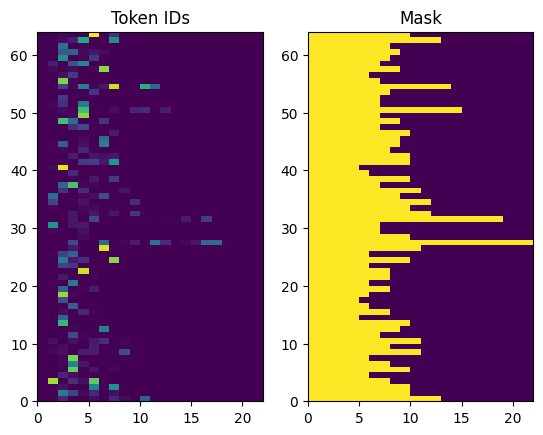

In [12]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [13]:
# Processing the dataset using the above defined layer
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [14]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[  2 786   1   4   3   0   0   0   0   0]

[   2   53 3041    7  335  214    4    0    0    0]
[  53 3041    7  335  214    4    3    0    0    0]


### The encoder/decoder

In [15]:
UNITS = 256

In [16]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units): # units represents the embedding dimension d
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # Embedding layer
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # RNN layer
    self.rnn = tf.keras.layers.Bidirectional(
    merge_mode='sum',
    layer=tf.keras.layers.GRU(units,
                        # Return the sequence and state
                        return_sequences=True,
                        recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context




In [17]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 22)
Encoder output, shape (batch, s, units): (64, 22, 256)


In [18]:
r1 = tf.constant([[[1, 2, 3], [1, 6, 7]],
                  [[2, 3, 2], [9, 0, 1]]]
                 )
print(r1)

tf.Tensor(
[[[1 2 3]
  [1 6 7]]

 [[2 3 2]
  [9 0 1]]], shape=(2, 2, 3), dtype=int32)


In [19]:
tf.reduce_mean(r1, 0)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 2],
       [5, 3, 4]], dtype=int32)>

In [20]:
tf.reduce_mean(r1, 1)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 4, 5],
       [5, 1, 1]], dtype=int32)>

In [21]:
tf.reduce_mean(r1, 2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2, 4],
       [2, 3]], dtype=int32)>

In [22]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [23]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 22, 256)
Target sequence, shape (batch, t, units): (64, 21, 256)
Attention result, shape (batch, t, units): (64, 21, 256)
Attention weights, shape (batch, t, s):    (64, 21, 22)


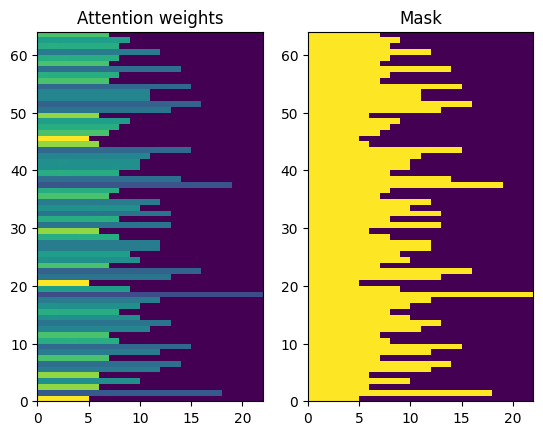

In [24]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

In [25]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [26]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [27]:
decoder = Decoder(target_text_processor, UNITS)

In [28]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 22, 256)
input target tokens shape: (batch, t) (64, 21)
logits shape shape: (batch, target_vocabulary_size) (64, 21, 5000)


In [29]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)  # represents that none of the sentences have been completed
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [30]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ') # It combines the words into a single string, separated by spaces.
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [31]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [32]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()


array([b'themselves limits differences goes dies chicken paranoid accompany cuts included',
       b'blind concluded link exam allowed wearing cage millionaire thrilled copy',
       b'collected both time exam increased offered strongly awoke economics hed'],
      dtype=object)

In [33]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [34]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 22)
Target tokens, shape: (batch, t) (64, 21)
logits, shape: (batch, t, target_vocabulary_size) (64, 21, 5000)


### Training

In [35]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [36]:
#The returned value represents the accuracy metric for the batch. It is the ratio of
# correct predictions to the total number of valid predictions in y_true.

def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [37]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [38]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [39]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 8s 25ms/step - loss: 8.5228 - masked_acc: 8.7719e-05 - masked_loss: 8.5228


{'loss': 8.522777557373047,
 'masked_acc': 8.771930151851848e-05,
 'masked_loss': 8.522777557373047}

In [40]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 37s 214ms/step - loss: 5.0019 - masked_acc: 0.2609 - masked_loss: 5.0019 - val_loss: 4.0761 - val_masked_acc: 0.3569 - val_masked_loss: 4.0761
Epoch 2/100
100/100 [==============================] - 10s 97ms/step - loss: 3.6756 - masked_acc: 0.4062 - masked_loss: 3.6756 - val_loss: 3.3030 - val_masked_acc: 0.4558 - val_masked_loss: 3.3030
Epoch 3/100
100/100 [==============================] - 6s 56ms/step - loss: 3.0950 - masked_acc: 0.4847 - masked_loss: 3.0950 - val_loss: 2.9256 - val_masked_acc: 0.5028 - val_masked_loss: 2.9256
Epoch 4/100
100/100 [==============================] - 6s 63ms/step - loss: 2.6641 - masked_acc: 0.5438 - masked_loss: 2.6641 - val_loss: 2.4729 - val_masked_acc: 0.5675 - val_masked_loss: 2.4729
Epoch 5/100
100/100 [==============================] - 5s 46ms/step - loss: 2.3801 - masked_acc: 0.5869 - masked_loss: 2.3801 - val_loss: 2.1754 - val_masked_acc: 0.6202 - val_masked_loss: 2.1754
Epoch 6/100
100/1

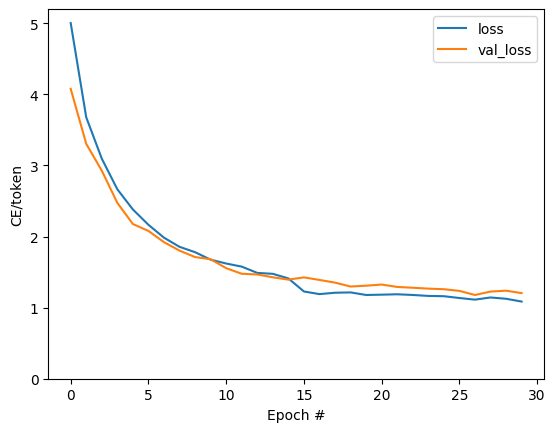

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

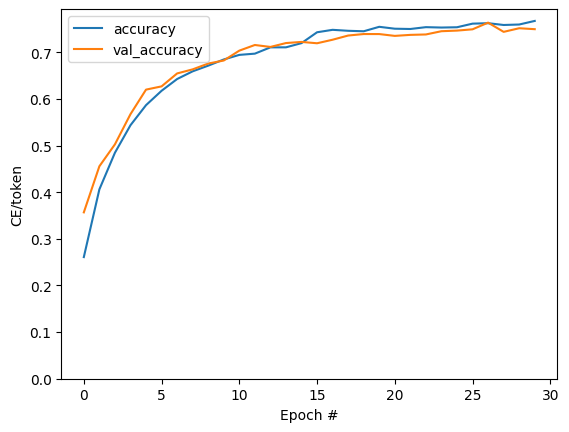

In [42]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Inference

In [43]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [44]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is he still home ? '

The translate function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [53]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

its very cold here . 
this is my life . 
his room is a disaster . 



### Export

To export this model I'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job done:

In [46]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [47]:
export = Export(model)

In [48]:
# Run the tf.function once to compile it
_ = export.translate(tf.constant(inputs))

In [49]:
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a disaster .                                            



In [50]:
# Now that the function has been traced it can be exported using saved_model.save:

tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

In [51]:
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [54]:
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a disaster .                                            



In [57]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [58]:
!zip -r folder.zip /content/translator


  adding: content/translator/ (stored 0%)
  adding: content/translator/saved_model.pb (deflated 91%)
  adding: content/translator/assets/ (stored 0%)
  adding: content/translator/variables/ (stored 0%)
  adding: content/translator/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/translator/variables/variables.index (deflated 70%)
  adding: content/translator/fingerprint.pb (stored 0%)


In [60]:
import shutil

shutil.move('folder.zip', '/content/drive/MyDrive/folder.zip')


'/content/drive/MyDrive/folder.zip'